In [1]:
#download vgg net weights
!wget -N https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

--2016-12-06 20:44:41--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com... 54.231.88.18
Connecting to s3.amazonaws.com|54.231.88.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Saving to: ‘vgg16.pkl’

vgg16.pkl           100%[===================>] 527.82M  2.06MB/s    in 5m 8s   

2016-12-06 20:49:50 (1.71 MB/s) - ‘vgg16.pkl’ saved [553459517/553459517]



In [26]:
import cPickle as pickle

import theano
import theano.tensor as T

import lasagne
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer #non gpu version
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
import urllib
import io
import skimage.transform

In [29]:
with open('/Users/augustus/python/weights/vgg16.pkl', 'rb') as f:
        model = pickle.load(f)

weights = model['param values']  # list of network weight tensors
classes = model['synset words']  # list of class names
mean_pixel = model['mean value']  # mean pixel value (in BGR)

del model

In [22]:
net = {}
net['input'] = InputLayer((None, 3, 224, 224))
net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
net['pool1'] = PoolLayer(net['conv1_2'], 2)
net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
net['pool2'] = PoolLayer(net['conv2_2'], 2)
net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
net['pool3'] = PoolLayer(net['conv3_3'], 2)
net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
net['pool4'] = PoolLayer(net['conv4_3'], 2)
net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
net['pool5'] = PoolLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['fc7'] = DenseLayer(net['fc6'], num_units=4096)
net['fc8'] = DenseLayer(net['fc7'], num_units=1000, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

lasagne.layers.set_all_param_values(net['prob'], weights)

In [25]:
def prepare_image(url):
    ext = url.rsplit('.', 1)[1]
    img = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = img.shape
    if h < w:
        img = skimage.transform.resize(img, (256, w*256/h), preserve_range=True)
    else:
        img = skimage.transform.resize(img, (h*256/w, 256), preserve_range=True)
    # Central crop to 224x224
    h, w, _ = img.shape
    img = img[h//2-112:h//2+112, w//2-112:w//2+112]
    # Remember this, it's a single RGB image suitable for plt.imshow()
    img_original = img.astype('uint8')
    # Shuffle axes from 01c to c01
    img = img.transpose(2, 0, 1)
    # Convert from RGB to BGR
    img = img[::-1]
    # Subtract mean pixel value
    img = img - mean_pixel[:, np.newaxis, np.newaxis]
    # Return the original and the prepared image (as a batch of a single item)
    return img_original, lasagne.utils.floatX(img[np.newaxis])

In [27]:
def compile_saliency_function(net):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = net['input'].input_var
    outp = lasagne.layers.get_output(net['fc8'], deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])

In [39]:
def show_images(img_original, saliency, max_class, title):
    # get out the first map and class from the mini-batch
    saliency = saliency[0]
    max_class = max_class[0]
    # convert saliency from BGR to RGB, and from c01 to 01c
    saliency = saliency[::-1].transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.suptitle("Class: " + classes[max_class] + ". Saliency: " + title)
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(img_original)
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.show()

## Plain gradient

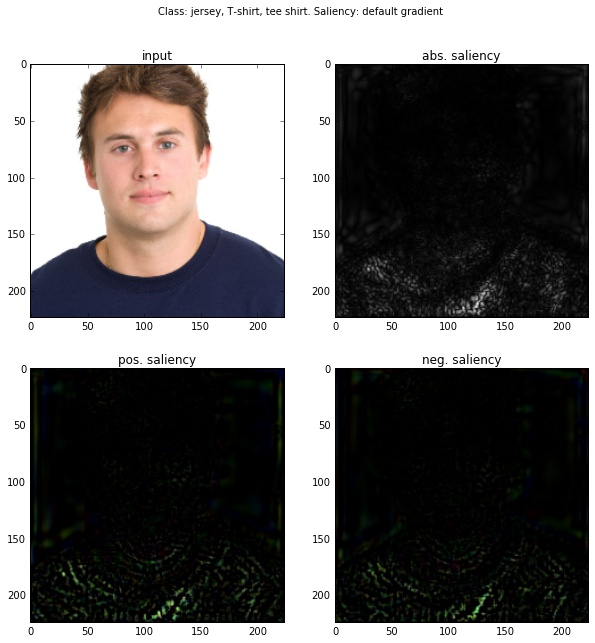

In [51]:
url = "https://www.nationaleombudsman.nl/uploads/2012_jonge_man.jpg"
img_original, img = prepare_image(url)

saliency_fn = compile_saliency_function(net)
saliency, max_class = saliency_fn(img)
show_images(img_original, saliency, max_class, "default gradient")

#hm not so good

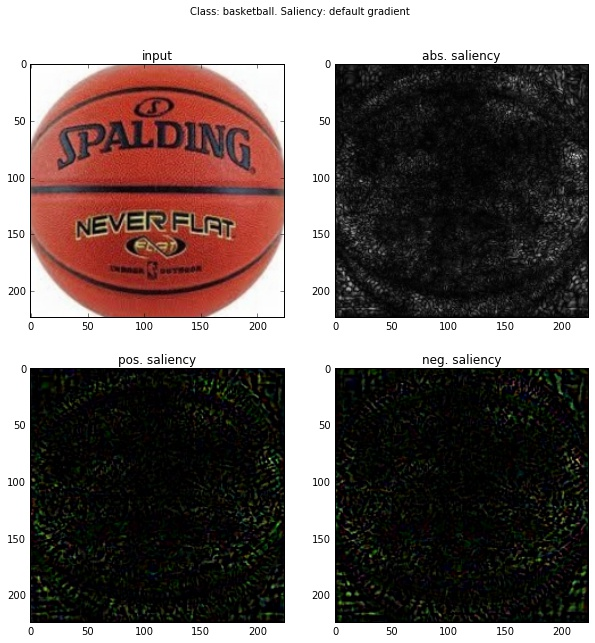

In [55]:
url = "http://76.my/UserImages/Items/TB220/152/907/152907135.jpg"
img_original, img = prepare_image(url)

saliency_fn = compile_saliency_function(net)
saliency, max_class = saliency_fn(img)
show_images(img_original, saliency, max_class, "default gradient")

## Guided backprop

In [57]:
class ModifiedBackprop(object):

    def __init__(self, nonlinearity):
        self.nonlinearity = nonlinearity
        self.ops = {}  # memoizes an OpFromGraph instance per tensor type

    def __call__(self, x):
        # OpFromGraph is oblique to Theano optimizations, so we need to move
        # things to GPU ourselves if needed.
        if theano.sandbox.cuda.cuda_enabled:
            maybe_to_gpu = theano.sandbox.cuda.as_cuda_ndarray_variable
        else:
            maybe_to_gpu = lambda x: x
        # We move the input to GPU if needed.
        x = maybe_to_gpu(x)
        # We note the tensor type of the input variable to the nonlinearity
        # (mainly dimensionality and dtype); we need to create a fitting Op.
        tensor_type = x.type
        # If we did not create a suitable Op yet, this is the time to do so.
        if tensor_type not in self.ops:
            # For the graph, we create an input variable of the correct type:
            inp = tensor_type()
            # We pass it through the nonlinearity (and move to GPU if needed).
            outp = maybe_to_gpu(self.nonlinearity(inp))
            # Then we fix the forward expression...
            op = theano.OpFromGraph([inp], [outp])
            # ...and replace the gradient with our own (defined in a subclass).
            op.grad = self.grad
            # Finally, we memoize the new Op
            self.ops[tensor_type] = op
        # And apply the memoized Op to the input we got.
        return self.ops[tensor_type](x)
    
class GuidedBackprop(ModifiedBackprop):
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return (grd * (inp > 0).astype(dtype) * (grd > 0).astype(dtype),)

In [58]:
relu = lasagne.nonlinearities.rectify
relu_layers = [layer for layer in lasagne.layers.get_all_layers(net['prob'])
               if getattr(layer, 'nonlinearity', None) is relu]
modded_relu = GuidedBackprop(relu)  # important: only instantiate this once!
for layer in relu_layers:
    layer.nonlinearity = modded_relu

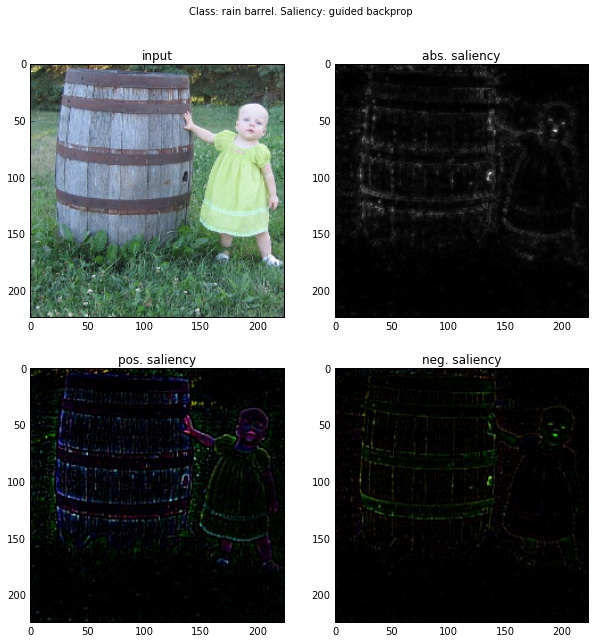

In [61]:
url = "http://farm1.static.flickr.com/73/209443372_a952d7f942.jpg"
img_original, img = prepare_image(url)

saliency_fn = compile_saliency_function(net)
saliency, max_class = saliency_fn(img)
show_images(img_original, saliency, max_class, "guided backprop")

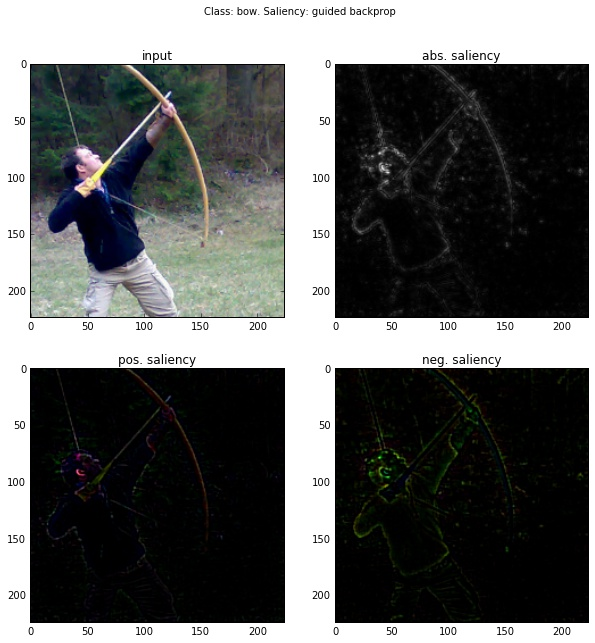

In [63]:
url = "http://farm1.static.flickr.com/216/458833837_119569ef3e.jpg"
img_original, img = prepare_image(url)

saliency_fn = compile_saliency_function(net)
saliency, max_class = saliency_fn(img)
show_images(img_original, saliency, max_class, "guided backprop")

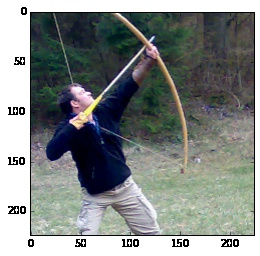

In [64]:
plt.imshow(img_original)

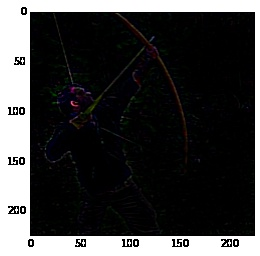

In [70]:
saliency = saliency[0]
saliency = saliency[::-1].transpose(1, 2, 0)

plt.imshow((np.maximum(0, saliency) / saliency.max()))